# Increase in Gases Compared to Temp

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import os, warnings
from scipy.signal import savgol_filter
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#import country temp and gas data
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
co2 = pd.read_csv('../data/CO2emissions/co2.csv')
methane = pd.read_csv('../data/methane/methane.csv')
no2 = pd.read_csv('../data/no2/no2.csv')

In [3]:
#the gas data requires a lot of cleaning to get into a form similar to the temp data
#takes in gas data set and produces a dataframe with a format similar to the temp dataframes
def cleanData(df):
    data = []
    for each in df.values:
        info = each[0].split('\t')
        data.append(info)
    boo = DataFrame(data=data,columns= co2.columns.values[0].split('\t'))
    del boo['Country Code']
    del boo['Indicator Name']
    del boo['Indicator Code']
    dataset = DataFrame()
    countries = boo['Country Name'].unique()
    for country in countries:
        holder=boo[boo['Country Name']==country]
        for each in holder.columns[1:]:
            zoo=DataFrame()
            zoo['Country'] = holder['Country Name']
            zoo['Year'] = each
            zoo['Emissions'] = holder[each]
            dataset = dataset.append(zoo)
    dataset['Emissions'] = dataset['Emissions'].apply(lambda x:None if x=='' else float(x))
    dataset = dataset.dropna().reset_index(drop=True)
    return(dataset)

In [4]:
#clean gas data and combine into one dataframe
codata = cleanData(co2) #metric tons
codata.rename(columns={'Emissions':'CO2 Emissions'},inplace=True)
medata = cleanData(methane) #kt of CO2 equivalent
medata['Emissions'] = medata['Emissions'].apply(lambda x:x*1000)
medata.rename(columns={'Emissions':'Methane Emissions'},inplace=True)
nodata = cleanData(no2) #kt of CO2 equivalent
nodata['Emissions'] = nodata['Emissions'].apply(lambda x:x*1000)
nodata.rename(columns={'Emissions':'NO2 Emissions'},inplace=True)
gasData = pd.merge(codata,medata,on=['Country','Year'],how='outer')
gasData = pd.merge(gasData,nodata,on=['Country','Year'],how='outer')
# gasData.head()

In [5]:
#remove unwanted gas data
gasData['Total Emissions'] = gasData['CO2 Emissions'] + gasData['NO2 Emissions'] + gasData['Methane Emissions']
exclusions = ['IDA','Low & middle income','World',
              'Middle income','IBRD','IDA total',
              'North America','South America','Europe',
              'Asia','Africa','income',
              'Antarcita','IDA','&','demographic','poor','Fragile','countries','OECD','area']
for each in exclusions:
    gasData = gasData[~gasData['Country'].str.contains(each)]
# gasData.head()

In [6]:
#remove unwanted temp data
countryTemp = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Australia','Antarcita']
#Remove continents from country temp
countryTemp = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTemp = countryTemp[~countryTemp['Country'].str.contains('(Europe)')]
countryTemp = countryTemp.dropna()
countryTemp['dt'] = pd.to_datetime(countryTemp['dt'])
countryTemp['Year'] = countryTemp['dt'].apply(lambda x : x.strftime('%Y'))
yearTemp = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)

In [7]:
#takes in country and plots the gas data for it
def plotGases(zoo):
    holder = gasData[gasData['Country'] == zoo]
    plt.figure(figsize=(6.5,4))
    host = host_subplot(111, axes_class=AA.Axes)
    ax = host.twinx()
    ax2 = host.twinx()
    
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis['right'] = new_fixed_axis(loc='right',axes=ax2,offset=(55,0))

    co=host.plot(holder['Year'],holder['CO2 Emissions'], label='CO2')
    me=ax.plot(holder['Year'],holder['Methane Emissions'], label='Methane')
    no=ax2.plot(holder['Year'],holder['NO2 Emissions'], label='NO2')
    
    host.set_title('Gas Emissions of '+zoo+' (Metric Tons of C02)')
    host.set_ylabel('CO2 Emissions')
    ax.set_ylabel('Methane Emissions')
    ax2.set_ylabel('NO2 Emissions')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    host.legend()
    
#     host.axis['left'].label.set_color(co.get_color())
#     ax.axis['right'].label.set_color(me.get_color())
#     ax2.axis['right'].label.set_color(no.get_color())

In [8]:
#calculate the rate of change of gas emissions over five year periods
data = DataFrame()
for each in gasData['Country'].unique():
    holder = gasData[gasData['Country'] == each]
    holderAvg = holder['Total Emissions'].mean()
    trimHolder = holder[['Year']+['Total Emissions']]
    trimHolder = trimHolder.set_index('Year',drop=True)
    diffChange = trimHolder.diff(5)
    diffChange = diffChange.dropna().reset_index(drop=False)
    diffChange['Country'] = each
    diffChange.rename(columns={'Total Emissions':'Emissions Change'},inplace=True)
    data = data.append(diffChange)
    
# data = data.sort_values('TempChange')
data['AbsEmissionsChange'] = data['Emissions Change'].apply(lambda x : abs(x))
data = data.sort_values('AbsEmissionsChange', ascending=False).reset_index(drop=True)
data = data.sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=True)
# data=data.groupby('Country').max().sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=False)
# data.head(10)

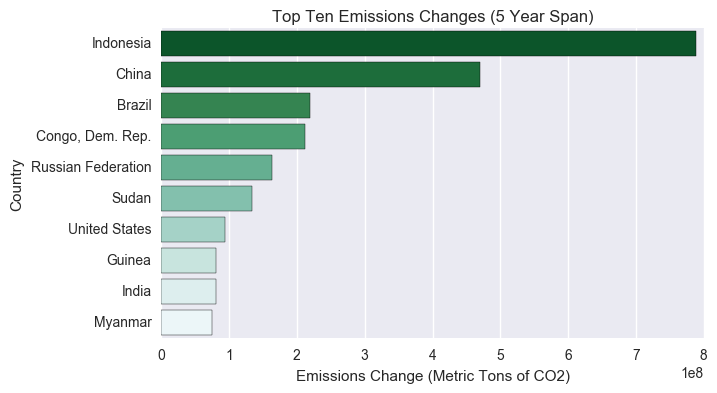

In [9]:
#graph the ten unique countries with the highest rates of change
graphData=data.groupby('Country').max().sort_values('AbsEmissionsChange',ascending=False).reset_index(drop=False)
plt.figure(figsize=(7,4))
ax = sns.barplot(graphData['AbsEmissionsChange'][0:10],graphData['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Emissions Change (Metric Tons of CO2)')
ax.set_title('Top Ten Emissions Changes (5 Year Span)')
plt.savefig("./ana_5/topTenEmissions.png", bbox_inches='tight',dpi=600)

In [10]:
#compile data for top five delta countries
emData = DataFrame()
for each in data['Country'].unique()[:5]:
    temp = gasData[gasData['Country']==each]
    temp['Count']=1
    emData = emData.append(temp)
# emData.head()

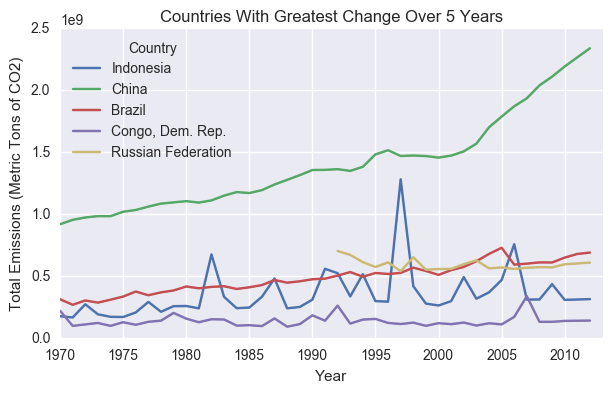

In [11]:
#plot total gas emissions of top five countries
plt.figure(figsize=(7,4))
ax=sns.tsplot(time='Year', value='Total Emissions',unit='Count',condition='Country',data=emData)
ax.set_title('Countries With Greatest Change Over 5 Years')
ax.set_ylabel('Total Emissions (Metric Tons of CO2)')
plt.savefig("./ana_5/topFiveEmissionsPlot.png", bbox_inches='tight',dpi=600)

In [12]:
#take in country and plot total gas and yearly temp average
def plotGasVsTemp(zoo):
    gasholder = gasData[gasData['Country'] == zoo]
    yearholder = yearTemp[yearTemp['Country']==zoo]
    cut = str((int(gasholder['Year'].min())-10))
    yearholder = yearholder[yearholder['Year'] > cut]
#     yearholder = yearholder.sort_valu
    plt.figure(figsize=(6.5,4))
    host = host_subplot(111, axes_class=AA.Axes)
    ax = host.twinx()
    
#     new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
#     ax2.axis['right'] = new_fixed_axis(loc='right',axes=ax2,offset=(55,0))
#     gasholder['Total Emissions'] = savgol_filter(gasholder['Total Emissions'], 5, 1)
#     yearholder['AverageTemperature'] = savgol_filter(yearholder['AverageTemperature'], 3, 1)
    
    host.plot(gasholder['Year'],gasholder['Total Emissions'], label='CO2')
    ax.plot(yearholder['Year'],yearholder['AverageTemperature'], label='Temp')
#     ax2.plot(holder['Year'],holder['NO2 Emissions'], label='NO2')
    
    host.set_title('Gas Emissions vs Average Temperature of '+zoo )
    host.set_ylabel('Total Emissions (Metric Tons of CO2)')
    ax.set_ylabel('AverageTemp')
#     ax2.set_ylabel('NO2 Emissions')
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
#     ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    host.legend()
    
#     host.axis['left'].label.set_color(co.get_color())
#     ax.axis['right'].label.set_color(me.get_color())
#     ax2.axis['right'].label.set_color(no.get_color())

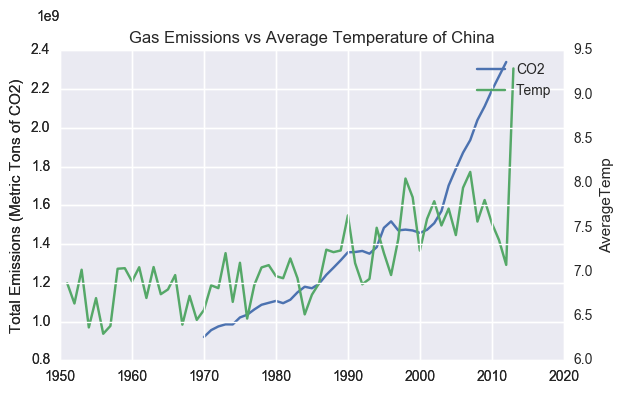

In [13]:
#plot China's gas and temp data
plotGasVsTemp('China')
plt.savefig("./ana_5/ChinaGasVsTemp.png", bbox_inches='tight', dpi=600)

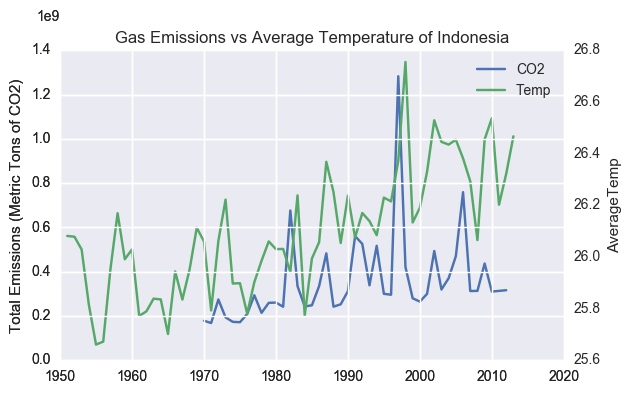

In [14]:
#plot Indonesia's gas and temp data
plotGasVsTemp('Indonesia')
plt.savefig("./ana_5/IndoGasVsTemp.png", bbox_inches='tight',dpi=600)

In [15]:
#calculate the gas emissions delta for each country between 1970 and 2013
tempGas = gasData.dropna()
countries = tempGas['Country'].unique()
listHolder = []
for each in countries:
    holder = tempGas[tempGas['Country'] == each]
    holder.sort_values('Year')
    oldTemp = holder['Total Emissions'].head(5).mean()
    minYear = holder['Year'].iloc[0]
    newTemp = holder['Total Emissions'].tail(5).mean()
    diffTemp = newTemp - oldTemp
    listHolder.append((each,minYear,oldTemp,newTemp,diffTemp))
    
diffs = DataFrame(listHolder, columns=('Country',
                                       'FirstYear',
                                       'OldEmissions',
                                       'NewEmissions',
                                       'DiffEmissions')).sort_values(by='DiffEmissions', ascending=False).reset_index(drop=True)

# diffs.head(10)

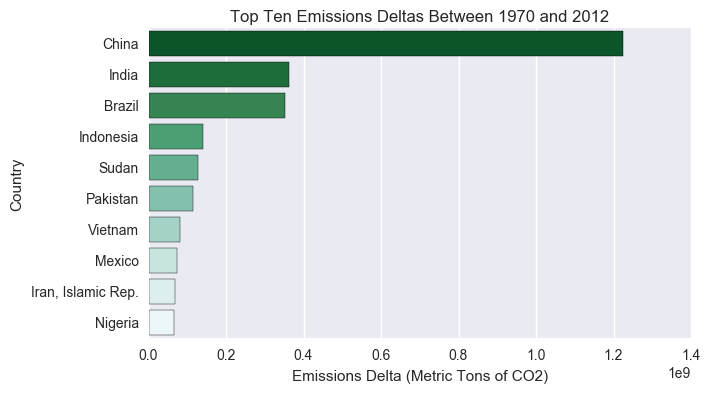

In [19]:
#plot ten countries with the highest emissions change
plt.figure(figsize=(7,4))
ax = sns.barplot(diffs['DiffEmissions'][0:10],diffs['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Emissions Delta (Metric Tons of CO2)')
ax.set_title('Top Ten Emissions Deltas Between 1970 and 2012')
plt.savefig("./ana_5/topDeltas.png", bbox_inches='tight',dpi=600)

In [20]:
#compile data for top five countries to plot
somData = DataFrame()
for each in diffs['Country'].unique()[:5]:
    temp = gasData[gasData['Country']==each]
    temp['Count']=1
    somData = somData.append(temp)

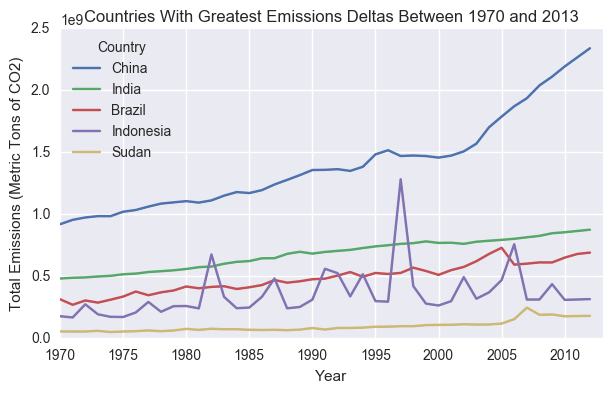

In [21]:
#plot those top five countries
plt.figure(figsize=(7,4))
ax=sns.tsplot(time='Year', value='Total Emissions',unit='Count',condition='Country',data=somData)
ax.set_title('Countries With Greatest Emissions Deltas Between 1970 and 2013')
ax.set_ylabel('Total Emissions (Metric Tons of CO2)')
ax.set_xlim(1970,2013)
plt.savefig("./ana_5/topDeltaPlot.png", bbox_inches='tight',dpi=600)

In [22]:
#create a dataframe of emissions data only from 2012
topEms = gasData[gasData['Year']=='2012'].sort_values('Total Emissions', ascending=False)
topEms = topEms.dropna()
# topEms.head(10)

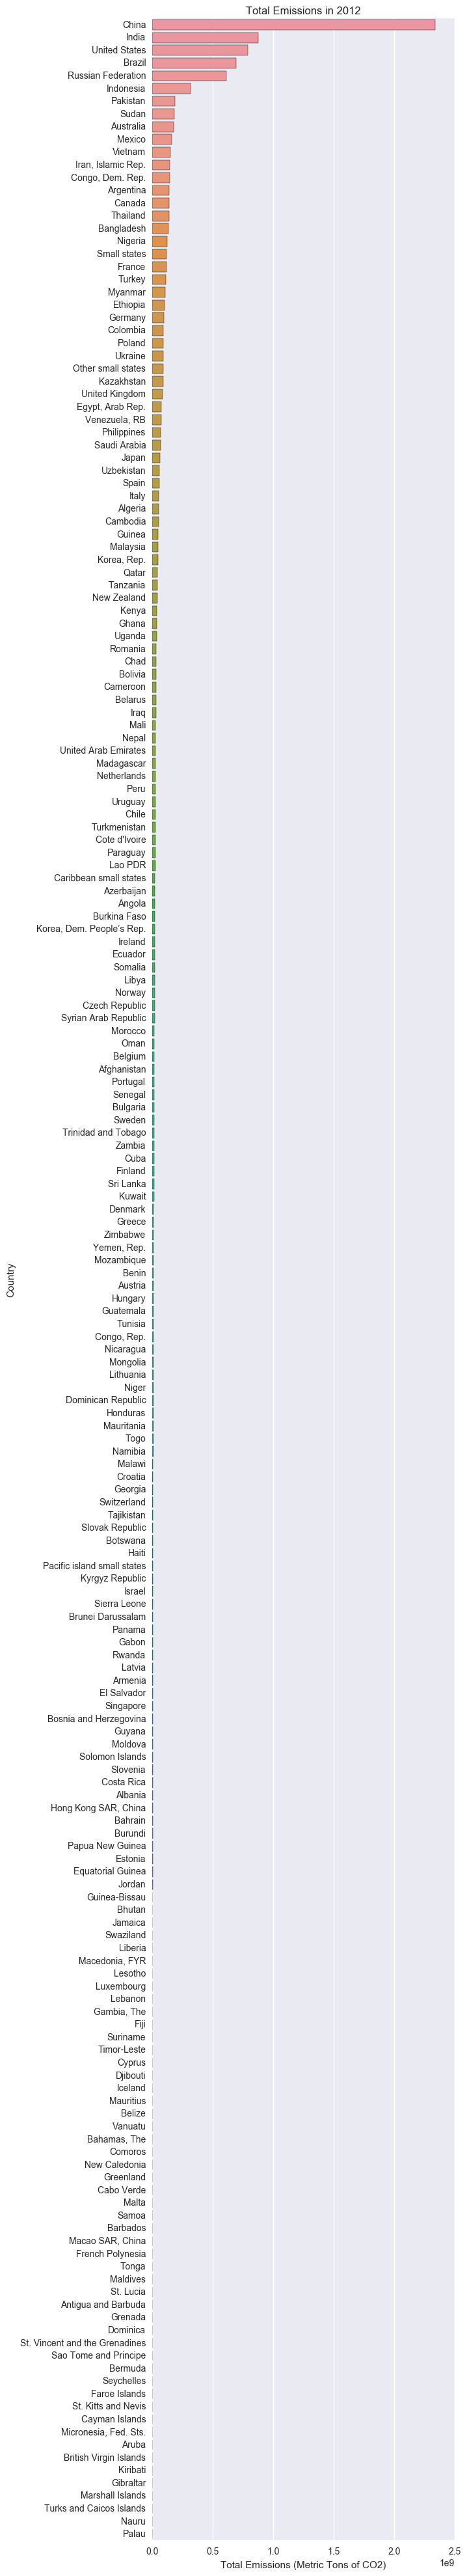

In [23]:
#plot 2012 emissions data from all countries
plt.figure(figsize=(6,50))
ax = sns.barplot(topEms['Total Emissions'],topEms['Country'])
ax.set_xlabel('Total Emissions (Metric Tons of CO2)')
ax.set_title('Total Emissions in 2012')
plt.savefig("./ana_5/topEmissions.png", bbox_inches='tight',dpi=600)

In [24]:
#compile emissions data for the five highest emitting countries in 2012
moreData = DataFrame()
for each in topEms['Country'].unique()[:5]:
    temp = gasData[gasData['Country']==each]
    temp['Count']=1
    moreData = moreData.append(temp)
# moreData.head()

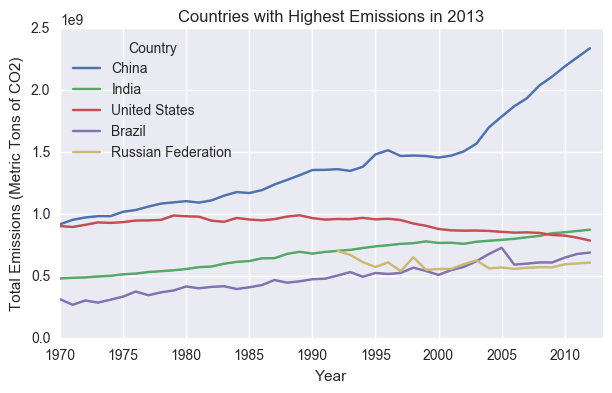

In [25]:
#plot the above data
plt.figure(figsize=(7,4))
ax=sns.tsplot(time='Year', value='Total Emissions',unit='Count',condition='Country',data=moreData)
ax.set_title('Countries with Highest Emissions in 2013')
ax.set_ylabel('Total Emissions (Metric Tons of CO2)')
ax.set_xlim(1970,2013)
plt.savefig("./ana_5/topEmsPlot.png", bbox_inches='tight',dpi=600)

In [26]:
#calculate temperaure delta data between 1970 and 2012 for every country
tempTemp = yearTemp[yearTemp['Year'] > '1970']
countries = tempTemp['Country'].unique()
listHolder = []
for each in countries:
    holder = tempTemp[tempTemp['Country'] == each]
    holder.sort_values('Year')
    oldTemp = holder['AverageTemperature'].head(5).mean()
    minYear = holder['Year'].iloc[0]
    newTemp = holder['AverageTemperature'].tail(5).mean()
    diffTemp = newTemp - oldTemp
    listHolder.append((each,minYear,oldTemp,newTemp,diffTemp))
    
tempDiffs = DataFrame(listHolder, columns=('Country',
                                       'FirstYear',
                                       'OldTemp',
                                       'NewTemp',
                                       'DiffTemp')).sort_values(by='DiffTemp', ascending=False).reset_index(drop=True)

tempDiffs = tempDiffs[['Country']+['DiffTemp']]
# tempDiffs.head()

In [27]:
#build new dataset for later merge
emsDiffs = diffs[['Country']+['DiffEmissions']]
# emsDiffs.head()

In [28]:
#merge temp and emission delta data
endData = pd.merge(tempDiffs,emsDiffs,on='Country',how='outer')
endData = endData.dropna()
# endData.head(25)

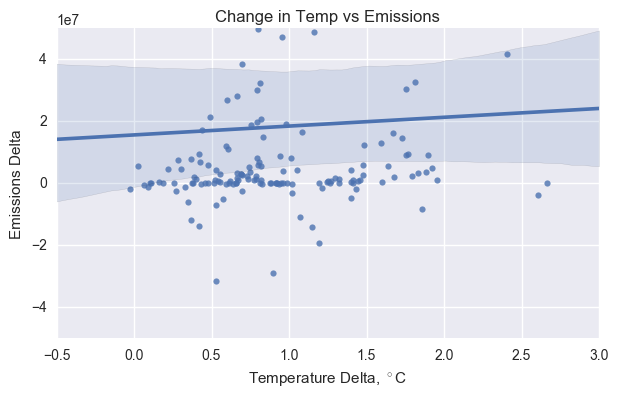

In [29]:
#plot emission delta vs temp delta
plt.figure(figsize=(7,4))
ax=sns.regplot(endData['DiffTemp'],endData['DiffEmissions']) 
ax.set_ylabel('Emissions Delta')
ax.set_xlabel('Temperature Delta, $^\circ$C')
ax.set_title('Change in Temp vs Emissions')
ax.set_ylim(-50000000,50000000)
plt.savefig("./ana_5/tempVsEms.png", bbox_inches='tight', dpi=600)